## Background

To learn how to code time series analysis based on the content of the book "Forecasting: Principles and Practice" by Rob J Hyndman and George Athanasopoulos.

This chapter mainly covers the time series components.

In [1]:
import os
import warnings

import datetime
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore",category=mpl.MatplotlibDeprecationWarning)
sns.set_style('darkgrid')
# sns.set(font_scale=1.5)

In [2]:
data = pd.read_csv("./data/elecsales.csv")

data['index'] = data['index'].apply(lambda x:int(x))

data.set_index('index', inplace=True)
data.index = pd.PeriodIndex(data.index, freq='Y')

data.head()

,value
index,
1989,2354.34
1990,2379.71
1991,2318.52
1992,2468.99
1993,2386.09


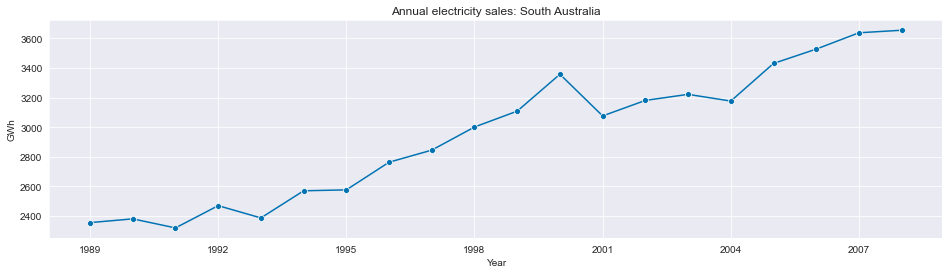

In [3]:
plot_series(data['value'])

plt.xlabel('Year')
plt.ylabel('GWh')
plt.title('Annual electricity sales: South Australia')
plt.show()

## Moving average smoothing

Page 203

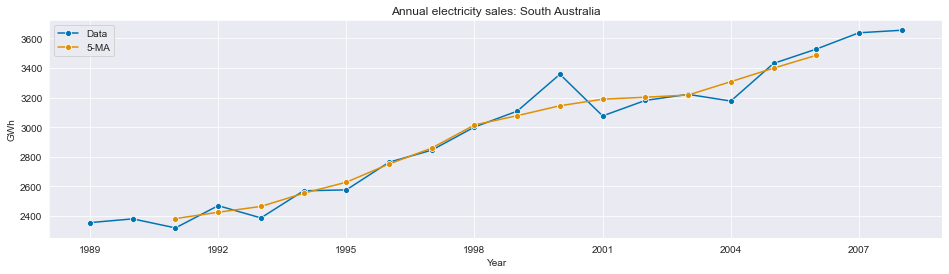

In [4]:
df = data.copy()

df['5-ma'] = df['value'].rolling(window=5).mean()
df['5-ma'] = df['5-ma'].shift(-2)

plot_series(df['value'], df['5-ma'], labels=['Data', '5-MA'])

plt.xlabel('Year')
plt.ylabel('GWh')
plt.title('Annual electricity sales: South Australia')
plt.show()

## Moving averages of moving averages

In general, an even order MA should be followed by an even order MA to make it symmetric. Similarly, an odd order MA should be followed by an odd order MA.

In [5]:
data = pd.read_csv("./data/ausbeer.csv")

data['index'] = data['index'].apply(lambda x: x.replace(' ', '-'))
qs = data['index'].tolist()

data['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
data['year'] = pd.DatetimeIndex(data['date']).year
data['quarter'] = data['index'].apply(lambda x: x.split('-')[1])

data = data[data['year']>=1992]

data['4-ma'] = data['value'].rolling(window=4).mean()
data['4-ma'] = data['4-ma'].shift(-2)

data['2x4-ma'] = data['4-ma'].rolling(window=2).mean()

data.head()

,index,value,date,year,quarter,4-ma,2x4-ma
144,1992-Q1,443,1992-01-01,1992,Q1,NaN,NaN
145,1992-Q2,410,1992-04-01,1992,Q2,451.25,NaN
146,1992-Q3,420,1992-07-01,1992,Q3,448.75,450.000
147,1992-Q4,532,1992-10-01,1992,Q4,451.50,450.125
148,1993-Q1,433,1993-01-01,1993,Q1,449.00,450.250


## Example: Electrical equipment manufacturing

Page 209

In [6]:
data = pd.read_csv("./data/elecequip.csv")

data.set_index('index', inplace=True)
data.index = pd.PeriodIndex(data.index, freq='M')

data.head()

,value
index,
1996-01,79.35
1996-02,75.78
1996-03,86.32
1996-04,72.60
1996-05,74.86


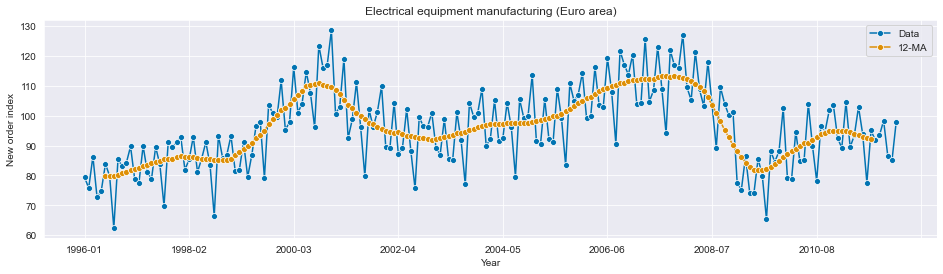

In [7]:
data['12-ma'] = data['value'].rolling(window=12).mean()
data['12-ma'] = data['12-ma'].shift(-6)

plot_series(data['value'], data['12-ma'], labels=['Data', '12-MA'])

plt.xlabel('Year')
plt.ylabel('New order index')
plt.title('Electrical equipment manufacturing (Euro area)')
plt.show()

## Classical decomposition

Page 212

In [8]:
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=13)

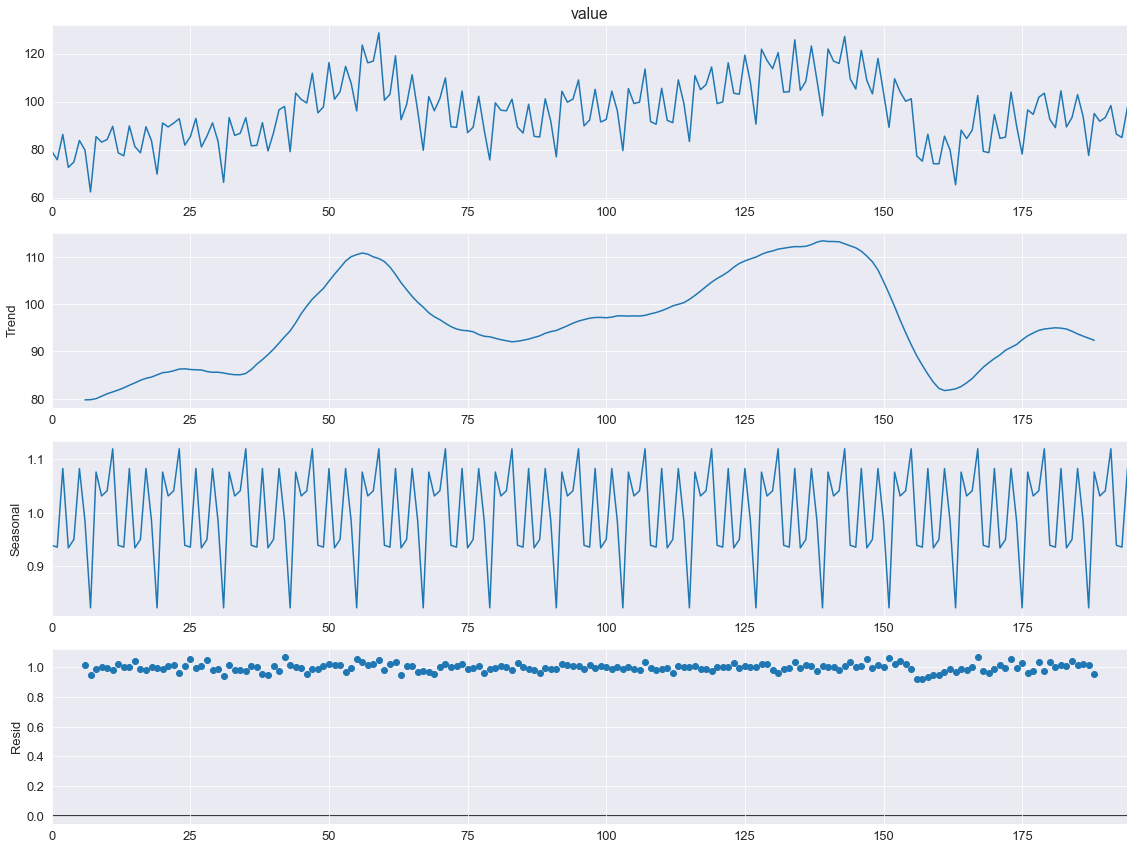

In [9]:
df = data.copy()
df.reset_index(inplace=True)

result = seasonal_decompose(df['value'], model='multiplicative', period=12)
result.plot()

plt.show()

## STL decomposition

Page 224

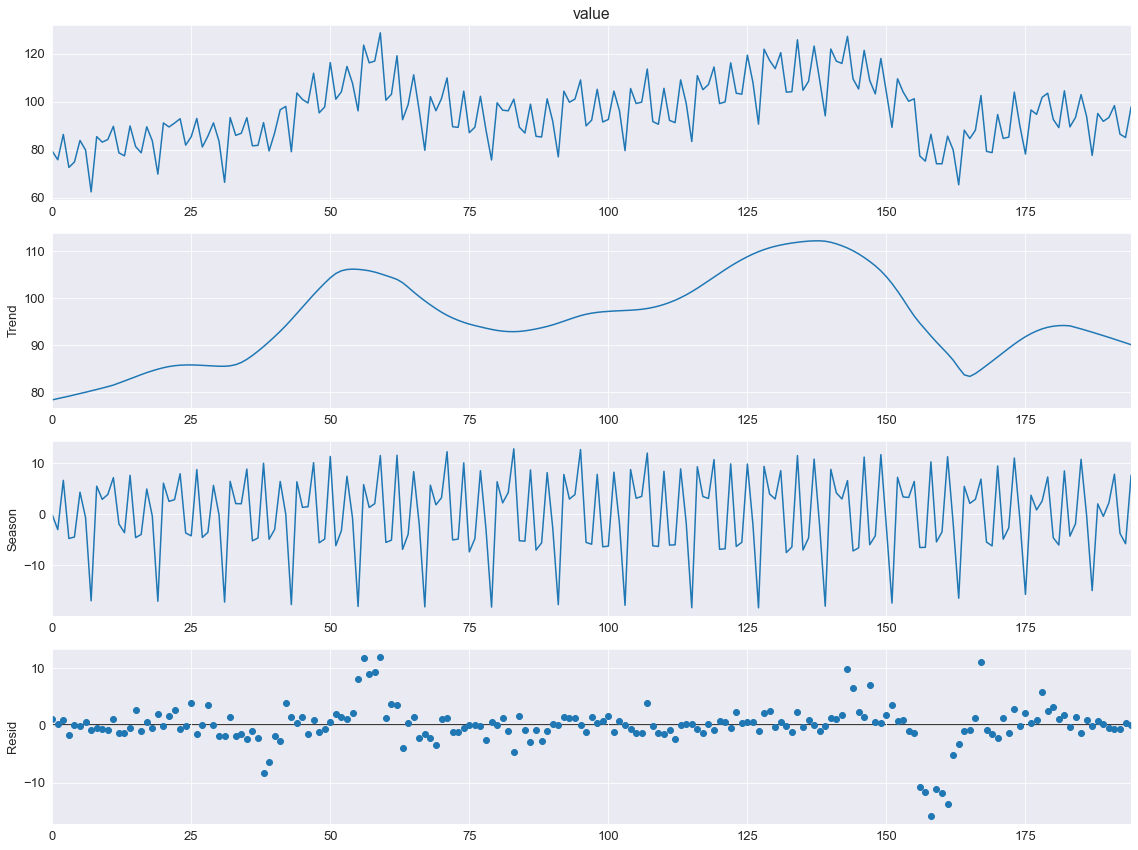

In [10]:
stl = STL(df['value'], period=12, robust=True)
res = stl.fit()
fig = res.plot()

## Forecasting with decomposition

Page 228

To forecast a decomposed time series, we forecast the seasonal component and the seasonally adjusted components separately. 

1. It is usually assumed that the seasonal component is unchanging, or changing extremely slow, so it is forecast by simply taking the last year of the estimated component. Therefore, a seasonal naive method can be used for the seasonal component.
2. To forecast the seasonally adjusted component, any non-seasonal forecasting method can be used.

In [11]:
### Example of each time series component
stl = STL(data['value'], period=12, robust=True)
res = stl.fit()
seasonal_comp = res.seasonal
trend_comp = res.trend

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

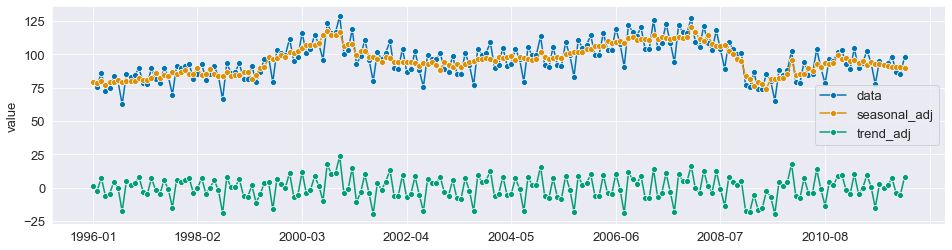

In [12]:
plot_series(data['value'], data['value']-seasonal_comp, data['value']-trend_comp, 
            labels=["data", "seasonal_adj", "trend_adj"])

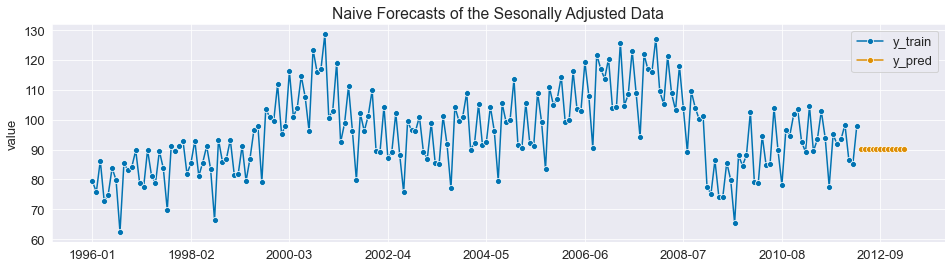

In [13]:
## Naive forecasts of the seasonally adjusted data
# step 1: specifying forecasting horizon
fh = np.arange(1, 13)
# step 2: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last")
# step 3: fitting the forecaster
adj_data = data['value']-seasonal_comp
forecaster.fit(y=adj_data)
# step 4: querying predictions
y_pred = forecaster.predict(fh)

plot_series(data['value'], y_pred, labels=["y_train", "y_pred"])
plt.title("Naive Forecasts of the Sesonally Adjusted Data")
plt.show()

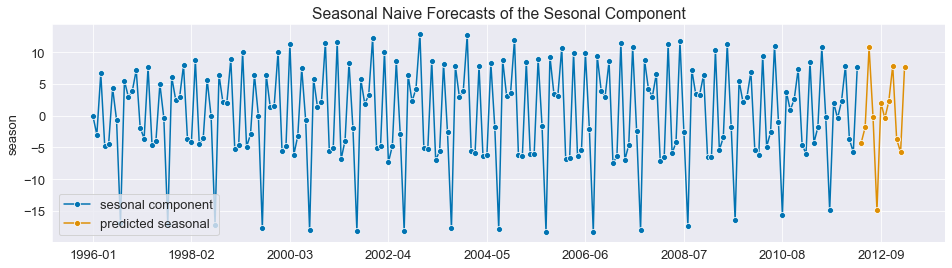

In [14]:
## Seasonal naive forecasts of the seasonal component
# step 1: specifying forecasting horizon
fh = np.arange(1, 13)
# step 2: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)
# step 3: fitting the forecaster
forecaster.fit(y=seasonal_comp)
# step 4: querying predictions
pred_seasonal = forecaster.predict(fh)

plot_series(seasonal_comp, pred_seasonal, labels=["sesonal component", "predicted seasonal"])
plt.title("Seasonal Naive Forecasts of the Sesonal Component")
plt.show()

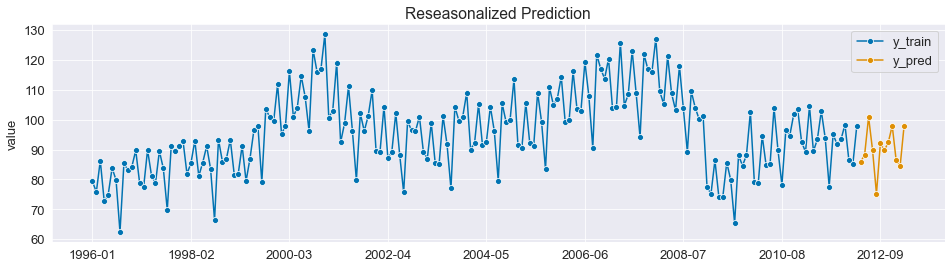

In [15]:
final_pred = y_pred+pred_seasonal

plot_series(data['value'], final_pred, labels=["y_train", "y_pred"])
plt.title("Reseasonalized Prediction")
plt.show()

### Use sktime library

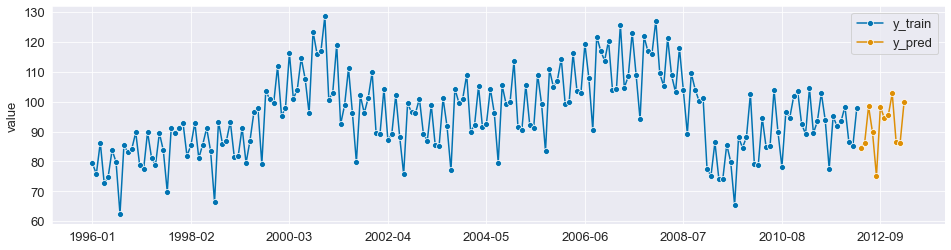

In [16]:
# specifying the forecasting horizon: one year ahead, all months
fh = np.arange(1, 13)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(data['value'])

y_pred = forecaster.predict(fh)
plot_series(data['value'], y_pred, labels=["y_train", "y_pred"])
plt.show()

---